In [34]:
! pip install --upgrade git+https://github.com/fatiando/harmonica

  Cloning https://github.com/fatiando/harmonica to c:\users\laisr\appdata\local\temp\pip-req-build-j1kvl559
  Resolved https://github.com/fatiando/harmonica to commit a05157dfe856de8a7a600672dabfe6cd69ef93c3
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/fatiando/harmonica 'C:\Users\laisr\AppData\Local\Temp\pip-req-build-j1kvl559'


In [35]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import warnings

In [36]:
warnings.filterwarnings('ignore')

In [37]:
region = [0, 100e3, 0, 90e3]
coordinates = vd.scatter_points(region, size=2000, extra_coords=2000, random_state=1)
inclination, declination = -20, -15
base_level = 500
noise_level = 200
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)

# Dipoles
dipole_coordinates = (20e3, 15e3, 1e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(7e10, inclination, declination),
    field="b",
)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))
dipole2_coordinates = (20e3, 80e3, 0e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=dipole2_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(5e11, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Pipe
size = 70
pipe_coordinates = (60e3, 80e3, 500)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        pipe_coordinates[0] - size,
        pipe_coordinates[0] + size,
        pipe_coordinates[1] - size,
        pipe_coordinates[1] + size,
        pipe_coordinates[2] - 10e3,
        pipe_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(15e3, -90, 0),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
# Dike
dike_coordinates = (30e3, 30e3, 900)
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        dike_coordinates[0] - 100e3,
        dike_coordinates[0] + 100e3,
        dike_coordinates[1] - 100,
        dike_coordinates[1] + 100,
        dike_coordinates[2] - 7e3,
        dike_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(200, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Line
line_coordinates = [30e3, 50e3, 0]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        line_coordinates[0] - 50,
        line_coordinates[0] + 50,
        line_coordinates[1],
        line_coordinates[1] + 100e3,
        line_coordinates[2] - 50,
        line_coordinates[2] + 50,
    ],
    magnetization=hm.magnetic_angles_to_vec(25e3, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))

# Sill
sill_coordinates = [80e3, 25e3, -0.5e3]
magnetic_field = hm.prism_magnetic(
    coordinates,
    prisms=[
        sill_coordinates[0] - 10e3,
        sill_coordinates[0] + 10e3,
        sill_coordinates[1] - 15e3,
        sill_coordinates[1] + 15e3,
        sill_coordinates[2] - 100,
        sill_coordinates[2] + 100,
    ],
    magnetization=hm.magnetic_angles_to_vec(200, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(magnetic_field, main_field))
# Regional
magnetic_anomaly += 0.01 * coordinates[0] - 0.02 * coordinates[1]

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(
    0, noise_level, size=magnetic_anomaly.shape
)
magnetic_anomaly += base_level

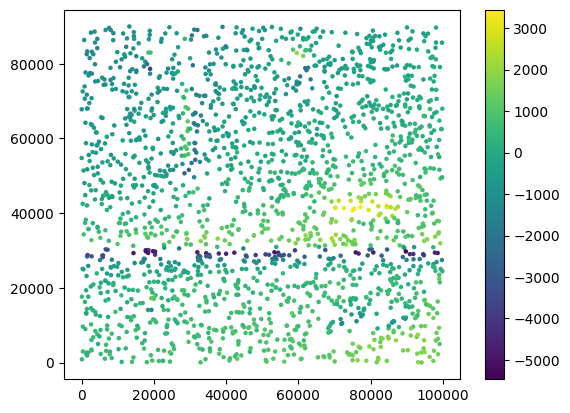

In [38]:
plt.scatter(coordinates[0], coordinates[1], s=5, c=magnetic_anomaly)
plt.colorbar()

In [39]:
# Equivalent sources

fonts = hm.EquivalentSourcesGB(damping=1,depth=1e3)
fonts.fit([coordinates[0],coordinates[1],coordinates[2]],data=magnetic_anomaly)

EquivalentSourcesGB(damping=1, depth=1000.0)

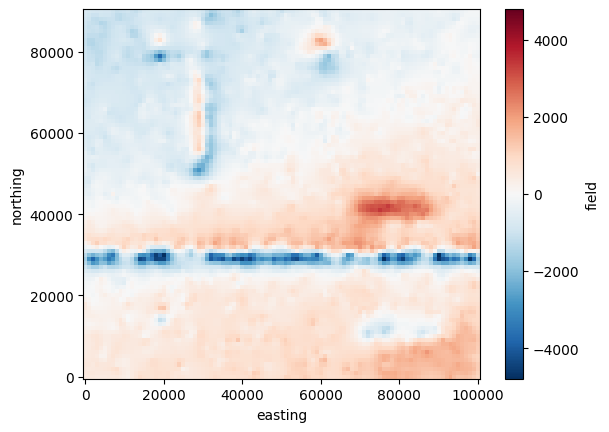

In [40]:
# Gridding equivalent sources

grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=2e3)
grid_eq = fonts.grid(grid_coords_eq,data_names="field")

grid_eq.field.plot()

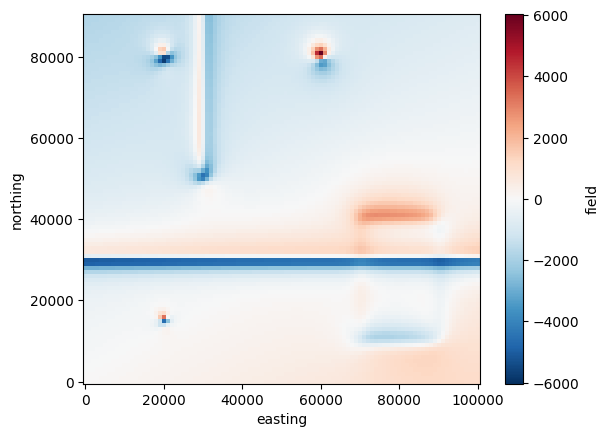

In [41]:
# Regular grid

coordinates_grid = vd.grid_coordinates(region, spacing=1000, extra_coords=2000)

# Multiple sources on regular grid
# Dipoles
dipole_coordinates = (20e3, 15e3, 1e3)
magnetic_field_grid = hm.dipole_magnetic(
    coordinates_grid,
    dipoles=dipole_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(7e10, inclination, declination),
    field="b",
)
magnetic_anomaly_grid = sum(b * f for b, f in zip(magnetic_field_grid, main_field))
dipole2_coordinates = (20e3, 80e3, 0e3)
magnetic_field_grid = hm.dipole_magnetic(
    coordinates_grid,
    dipoles=dipole2_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(5e11, inclination, declination),
    field="b",
)
magnetic_anomaly_grid += sum(b * f for b, f in zip(magnetic_field_grid, main_field))

# Pipe
size = 70
pipe_coordinates = (60e3, 80e3, 500)
magnetic_field_grid = hm.prism_magnetic(
    coordinates_grid,
    prisms=[
        pipe_coordinates[0] - size,
        pipe_coordinates[0] + size,
        pipe_coordinates[1] - size,
        pipe_coordinates[1] + size,
        pipe_coordinates[2] - 10e3,
        pipe_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(15e3, -90, 0),
    field="b",
)
magnetic_anomaly_grid += sum(b * f for b, f in zip(magnetic_field_grid, main_field))
# Dike
dike_coordinates = (30e3, 30e3, 900)
magnetic_field_grid = hm.prism_magnetic(
    coordinates_grid,
    prisms=[
        dike_coordinates[0] - 100e3,
        dike_coordinates[0] + 100e3,
        dike_coordinates[1] - 100,
        dike_coordinates[1] + 100,
        dike_coordinates[2] - 7e3,
        dike_coordinates[2],
    ],
    magnetization=hm.magnetic_angles_to_vec(200, inclination, declination),
    field="b",
)
magnetic_anomaly_grid += sum(b * f for b, f in zip(magnetic_field_grid, main_field))

# Line
line_coordinates = [30e3, 50e3, 0]
magnetic_field_grid = hm.prism_magnetic(
    coordinates_grid,
    prisms=[
        line_coordinates[0] - 50,
        line_coordinates[0] + 50,
        line_coordinates[1],
        line_coordinates[1] + 100e3,
        line_coordinates[2] - 50,
        line_coordinates[2] + 50,
    ],
    magnetization=hm.magnetic_angles_to_vec(25e3, inclination, declination),
    field="b",
)
magnetic_anomaly_grid += sum(b * f for b, f in zip(magnetic_field_grid, main_field))

# Sill
sill_coordinates = [80e3, 25e3, -0.5e3]
magnetic_field_grid = hm.prism_magnetic(
    coordinates_grid,
    prisms=[
        sill_coordinates[0] - 10e3,
        sill_coordinates[0] + 10e3,
        sill_coordinates[1] - 15e3,
        sill_coordinates[1] + 15e3,
        sill_coordinates[2] - 100,
        sill_coordinates[2] + 100,
    ],
    magnetization=hm.magnetic_angles_to_vec(200, inclination, declination),
    field="b",
)
magnetic_anomaly_grid += sum(b * f for b, f in zip(magnetic_field_grid, main_field))
# Regional
magnetic_anomaly_grid += 0.01 * coordinates_grid[0] - 0.02 * coordinates_grid[1]


grid_true = vd.make_xarray_grid(
    coordinates_grid[:2], (magnetic_anomaly_grid, coordinates_grid[-1]), data_names=["field", "height"]
)
grid_true.field.plot()

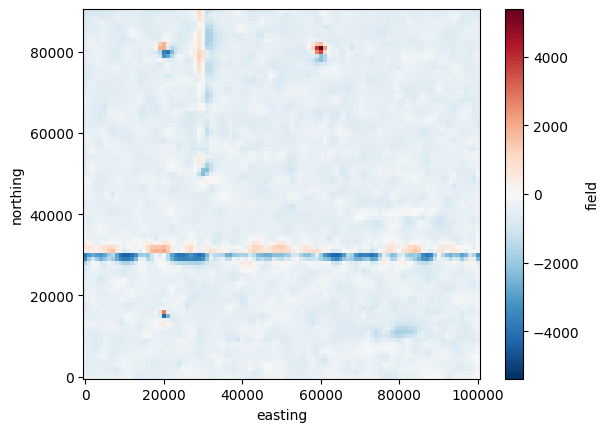

In [42]:
residuo = grid_true - grid_eq
residuo.field.plot()

In [43]:
media = np.sum(grid_true.field.values)/np.size(grid_true.field)
residuo_2 = np.sum(residuo.field.values**2)
R_2_true = 1 - (residuo_2/np.sum([(value - media)**2 for value in grid_true.field.values]))
R_2_true

0.6130149085756051

In [51]:
# Random cross-validation 

R_2_random = np.mean(vd.cross_val_score(fonts,coordinates,magnetic_anomaly))
R_2_random

0.8244458264042466

In [53]:
# Blocked cross-validation

block = np.arange(1000,10950,950) 
nsplits = 5
R_2_block = [] 

for spacing in block:
    R_2_block.append(np.mean(
        vd.cross_val_score(
            fonts,
            coordinates,
            magnetic_anomaly,
            cv=vd.BlockKFold(spacing=spacing, n_splits=nsplits, shuffle=True, random_state=123),
        )
    ))

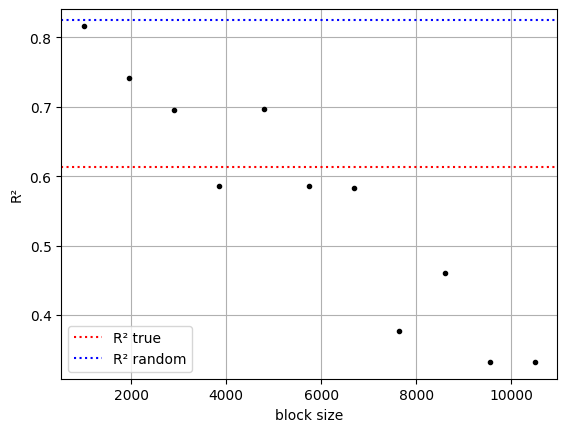

In [57]:
plt.plot(block,R_2_block,".k")
plt.xlabel("block size")
plt.ylabel("R²")
plt.axhline(y = R_2_true, color = 'red', linestyle = 'dotted', label="R² true") 
plt.axhline(y = R_2_random, color = 'blue', linestyle = 'dotted', label="R² random") 
plt.grid(True)
plt.legend()